In [54]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from sklearn import feature_selection, feature_extraction, manifold, decomposition, linear_model, cluster
from sklearn import linear_model, svm, neural_network, model_selection, preprocessing, tree, ensemble
from sklearn import gaussian_process, pipeline, metrics, dummy

import eli5
import xgboost

In [2]:
!ls data/

actual.csv			  data_set_ALL_AML_train.csv
data_set_ALL_AML_independent.csv  gene-expression.zip


In [3]:
train = pd.read_csv("data/data_set_ALL_AML_train.csv", delimiter=",")
test = pd.read_csv("data/data_set_ALL_AML_independent.csv", delimiter=",")
actual = pd.read_csv("data/actual.csv")
train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [4]:
test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [5]:
train.shape, test.shape, actual.shape

((7129, 78), (7129, 70), (72, 2))

In [6]:
X = (train.drop(["Gene Description", "Gene Accession Number"], axis=1)
          .drop([col for col in train.columns if "call" in col], axis=1)).values.T

X_test = (test.drop(["Gene Description", "Gene Accession Number"], axis=1)
               .drop([col for col in test.columns if "call" in col], axis=1)).values.T

In [7]:
X.shape

(38, 7129)

In [8]:
labels = actual.cancer.values
encoded_labels = preprocessing.LabelEncoder().fit_transform(labels)

y = encoded_labels[:X.shape[0]]
y_test = encoded_labels[X.shape[0]:]

descriptions = np.array(list(map(lambda x: x[:13], train["Gene Description"])))

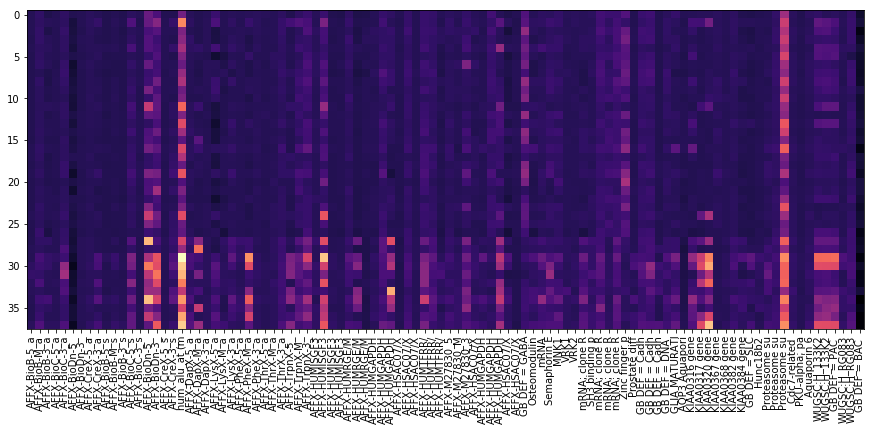

In [9]:
num = 100

X_sel = feature_selection.SelectKBest(k=num).fit_transform(X, y)
X_sel.shape

plt.figure(figsize=(15,10))
plt.xticks(range(num), descriptions[:num], rotation="vertical")
plt.imshow(X_sel, cmap="magma")
plt.show()

In [10]:
cls = ensemble.ExtraTreesClassifier(n_estimators=500)
cls.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
cls.feature_importances_

array([0.00058302, 0.        , 0.        , ..., 0.        , 0.00163466,
       0.        ])

In [12]:
important = np.argsort(cls.feature_importances_)[-100:]

In [13]:
def plot(idx):
    plt.figure(figsize=(15,10))
    plt.xticks(range(len(idx)), descriptions[idx], rotation="vertical")
    plt.yticks(range(len(X)), labels)
    plt.imshow(X[:,idx], cmap="magma")
    
    mask = np.ones_like(X)
    mask[(encoded_labels == 1)[:X.shape[0]], :] = 0
    plt.imshow(mask[:,:len(idx)], alpha=0.15, cmap="gray")
    

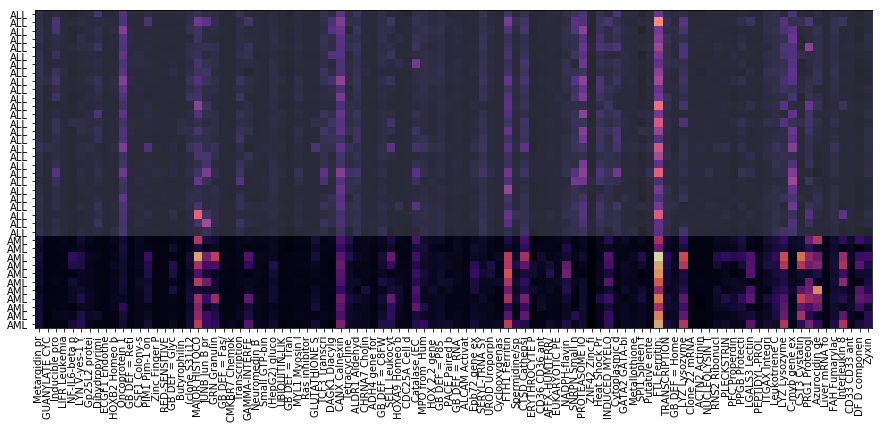

In [14]:
plot(important)

In [15]:
import eli5

In [16]:
lm = linear_model.LogisticRegressionCV().fit(X[:,important], y)
lm.score(X_test[:, important], y_test)

0.6176470588235294

In [17]:
eli5.show_weights(lm, top=10)

In [18]:
from xgboost import XGBClassifier

In [19]:
XGBClassifier().fit(X, y).score(X_test, y_test)

/home/darth/.miniconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6176470588235294

In [20]:
gaussian_process.GaussianProcessClassifier().fit(X, y).score(X_test, y_test)

0.5882352941176471

In [21]:
import skopt
from skopt.space import Integer, Real, Categorical

In [22]:
opt = skopt.BayesSearchCV(svm.SVC(),
                   {
                       "C": Real(1e-6, 1e6, prior="log_uniform"),
                       "gamma": Real(1e-6, 1e6, prior="log_uniform"),
                       "degree": Integer(1, 8),
                       "kernel": Categorical(["linear", "poly", "rbf"])
                   }, n_jobs=8)

# opt.fit(X, y)
# opt.score(X_test, y_test)

In [23]:
# opt.best_estimator_

In [24]:
pipe = pipeline.Pipeline([
    ("selection", feature_selection.SelectKBest()),
    ("model", svm.SVC())
])

linear_svm_search = {
    "selection__k": Integer(20, X.shape[0]),
    "model": [svm.LinearSVC()]
}

svc_search = {
    "selection__k": Integer(20, X.shape[0]),
    "model": [svm.SVC()],
    "model__C": Real(1e-6, 1e6, prior="log_uniform"),
    "model__gamma": Real(1e-6, 1e6, prior="log_uniform"),
    "model__degree": Integer(1, 8),
    "model__kernel": Categorical(["linear", "poly", "rbf"])
}

opt = skopt.BayesSearchCV(pipe, [(linear_svm_search, 10), (svc_search, 100)])

# opt.fit(X, y).score(X_test, y_test)

In [25]:
# opt.best_params_

In [26]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# tf.enable_eager_execution()

In [27]:
input_shape = X.shape[1]

In [28]:
# encoder = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=[input_shape]),
#     tf.keras.layers.Dense(500, activation=tf.nn.relu),
#     tf.keras.layers.Dense(500, activation=tf.nn.relu)    
# ])

# decoder = tf.keras.Sequential([
#     tf.keras.layers.Dense(500, activation=tf.nn.relu),
#     tf.keras.layers.Dense(500, activation=tf.nn.relu),
#     tf.keras.layers.Dense(input_shape)
# ])

In [29]:
# X_tf = tf.convert_to_tensor(X, dtype=tf.float32)

In [30]:
# encoder(X_tf)

In [77]:
gaussian_process.GaussianProcessClassifier().fit(X, y).score(X_test, y_test)

0.5882352941176471

In [34]:
z_dim = 100


tf.reset_default_graph()

img = tf.placeholder(tf.float32, shape=[None, input_shape], name="img")

def encoder(img):
    with tf.variable_scope("encoder"):
        hidden = tf.layers.dense(img, 500, activation=tf.nn.relu)
        hidden = tf.layers.dense(hidden, 500, activation=tf.nn.relu)
    
    return hidden

def decoder(z):
    with tf.variable_scope("decoder"):
        hidden = tf.layers.dense(z, 500, activation=tf.nn.relu)
        hidden = tf.layers.dense(hidden, 500, activation=tf.nn.relu)
        
    out = tf.layers.dense(hidden, input_shape, name="output")    
    return out

z = encoder(img)
out = decoder(z)

loss = tf.losses.mean_squared_error(img, out)

global_step = tf.train.create_global_step()
training = tf.train.AdamOptimizer().minimize(loss, global_step=global_step, name="training")

summary_writer = tf.contrib.summary.create_file_writer("logs", flush_millis=5*1000)

with summary_writer.as_default(), tf.contrib.summary.record_summaries_every_n_global_steps(100):
    summaries = [
        tf.contrib.summary.scalar("loss", loss)
    ]
    
try:
    sess.close()
except NameError:
    print("No session defined, continuing.")

sess = tf.InteractiveSession()

with summary_writer.as_default():
    tf.contrib.summary.initialize(session=sess, graph=tf.get_default_graph())

init = tf.global_variables_initializer()
sess.run(init)

In [44]:
for _ in range(10000):
    sess.run([training, summaries], feed_dict={img: X})

In [46]:
X_embed = sess.run(z, feed_dict={img: X})
X_test_embed = sess.run(z, feed_dict={img: X_test})

In [53]:
svm.LinearSVC().fit(X_embed, y).score(X_test_embed, y_test)

0.5882352941176471

In [55]:
dummy.DummyClassifier().fit(X_embed, y).score(X_test_embed, y_test)

0.6764705882352942

In [75]:
linear_model.LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", C=.0001).fit(X_embed, y).score(X_test_embed, y_test)

0.5882352941176471

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))